### Импорты и настройки

In [1]:
import pandas as pd
import sqlalchemy
import re
import tqdm
import numpy as np
from preprocessing import Players, Seasons

pd.set_option('max_columns', None)

db_name = 'postgres'
db_hostname = 'localhost'
db_user = 'postgres'
db_password = 'tttBBB777'
db_table = 'players_list'

engine = sqlalchemy.create_engine(f'postgresql+psycopg2://{db_user}:{db_password}@{db_hostname}/{db_name}')

In [2]:
season = pd.read_sql('select * from player_season', engine)
players = pd.read_sql('select * from player', engine)

In [3]:
season_stats = Seasons.preprocess(season)
players = Players.preprocess(players)

### Подготовка фич

In [4]:
full_df = season_stats.merge(players, left_on='player_id', right_on='id')
full_df['age'] = (full_df['year'] - full_df['date_of_birth']) / np.timedelta64(1, 'Y')

#### Определение национальностей

In [5]:
nations = [x.split(' / ') for x in full_df['nation'].unique()]
nations = list(set([item for sublist in nations for item in sublist]))

In [6]:
for nation in tqdm.tqdm(nations):
    column = f'nation_{nation}'
    full_df.loc[full_df['nation'].str.contains(nation), column] = 1
    full_df[column].fillna(0, inplace=True)

100%|████████████████████████████████████████| 107/107 [02:12<00:00,  1.24s/it]


#### Определение позииции

In [7]:
positions = [x.split('_')[-1].split('/') for x in full_df['position'].unique()]
positions = list(set([item.upper() for sublist in positions for item in sublist]))

In [8]:
for position in tqdm.tqdm(positions):
    column = f'position_{position}'
    full_df.loc[full_df['position'].str.contains(position, case=False), column] = 1
    full_df[column].fillna(0, inplace=True)

100%|██████████████████████████████████████████| 10/10 [00:17<00:00,  1.70s/it]


#### Дамми-фичи

In [9]:
dummies = ['shoots', 'birth_country', 'nhl_rights', 'draft_team']

features_df = pd.concat([full_df, pd.get_dummies(full_df[dummies], drop_first=True)], axis=1)

#### Аггрегаты по игроку

In [10]:
groupby_columns = ['player_id', 'season', 'postseason_flag']
stats_columns = ['games', 'goals', 'assists', 'points', 'penalty', 'plus_minus']
aggregates = features_df.groupby(groupby_columns)[stats_columns].sum().reset_index()

In [11]:
regular = aggregates[aggregates['postseason_flag'] == 0].reset_index(drop=True).sort_values(['player_id', 'season'])
playoff = aggregates[aggregates['postseason_flag'] == 1].reset_index(drop=True).sort_values(['player_id', 'season'])

##### Аггрегаты по Postseason

In [12]:
max_window = 50

aggregations = []
for function in tqdm.tqdm(['sum', 'mean', 'max', 'min']):
    aggr = getattr(playoff.groupby(['player_id'])[stats_columns].rolling(max_window, 1), function)()
    aggr = aggr.groupby('player_id')[stats_columns].shift()
    aggr.columns = [f'{function}_{x}' for x in aggr.columns]
    aggregations.append(aggr.reset_index(drop=True))
playoff = playoff.merge(pd.concat(aggregations, axis=1), left_index=True, right_index=True)
playoff = playoff.drop(stats_columns, axis=1)

100%|████████████████████████████████████████████| 4/4 [02:57<00:00, 44.34s/it]


##### Аггрегаты по Regular Season

In [13]:
aggregations = []
for function in tqdm.tqdm(['sum', 'mean', 'max', 'min']):
    aggr = getattr(regular.groupby(['player_id'])[stats_columns].rolling(max_window, 1), function)()
    aggr = aggr.groupby('player_id')[stats_columns].shift()
    aggr.columns = [f'{function}_{x}' for x in aggr.columns]
    aggregations.append(aggr.reset_index(drop=True))
regular = regular.merge(pd.concat(aggregations, axis=1), left_index=True, right_index=True)
regular = regular.drop(stats_columns, axis=1)

100%|███████████████████████████████████████████| 4/4 [07:19<00:00, 109.95s/it]


In [14]:
shape_before = features_df.shape[0]
aggregated_features = regular.append(playoff, sort=False)
features_df = features_df.merge(aggregated_features, on=['player_id', 'season', 'postseason_flag'], how='left')
assert shape_before == features_df.shape[0], "Shapes doesn't match"

#### Приводим в порядок колонки

In [15]:
non_features = ['season', 'team', 'league', 'player_id', 'year', 'name', 'id', 'position', 'age', 'nation', 'shoots', 'youth team', 'date_of_birth', 
                'birth_country', 'birth_city', 'nhl_rights', 'draft_team', 'nation_', 'assists', 'points', 'penalty', 'plus_minus']
target = 'goals'

# Для правильного сплита - сортируем по возрастанию сезона
features_df = features_df[features_df[target].isnull() == False].sort_values(['season', 'postseason_flag']).reset_index(drop=True)
features_df.drop(non_features, axis=1, inplace=True)
features_df.rename(columns = lambda x: x.replace('/', '_'), inplace=True)
features_df = features_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

### Построение модели

In [35]:
from lightgbm import LGBMRegressor, plot_importance
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

In [36]:
X = features_df[[x for x in features_df.columns if x != target]]
y = features_df[target]

tscv = TimeSeriesSplit()
gbm = LGBMRegressor(max_depth=13, num_leaves=60, learning_rate=0.05, n_estimators=500)

In [38]:
scores = []

for train_index, test_index in tqdm.tqdm(tscv.split(X), total=tscv.n_splits):
    model = gbm.fit(X.loc[train_index], y.loc[train_index])
    prediction = model.predict(X.loc[test_index])
    scores.append(mean_absolute_error(y.loc[test_index], prediction))

100%|████████████████████████████████████████████| 5/5 [02:47<00:00, 33.55s/it]


In [39]:
scores

[3.677610915945633,
 3.4993465544781173,
 3.2690947619457424,
 3.1398027712181436,
 2.9139544055769053]

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

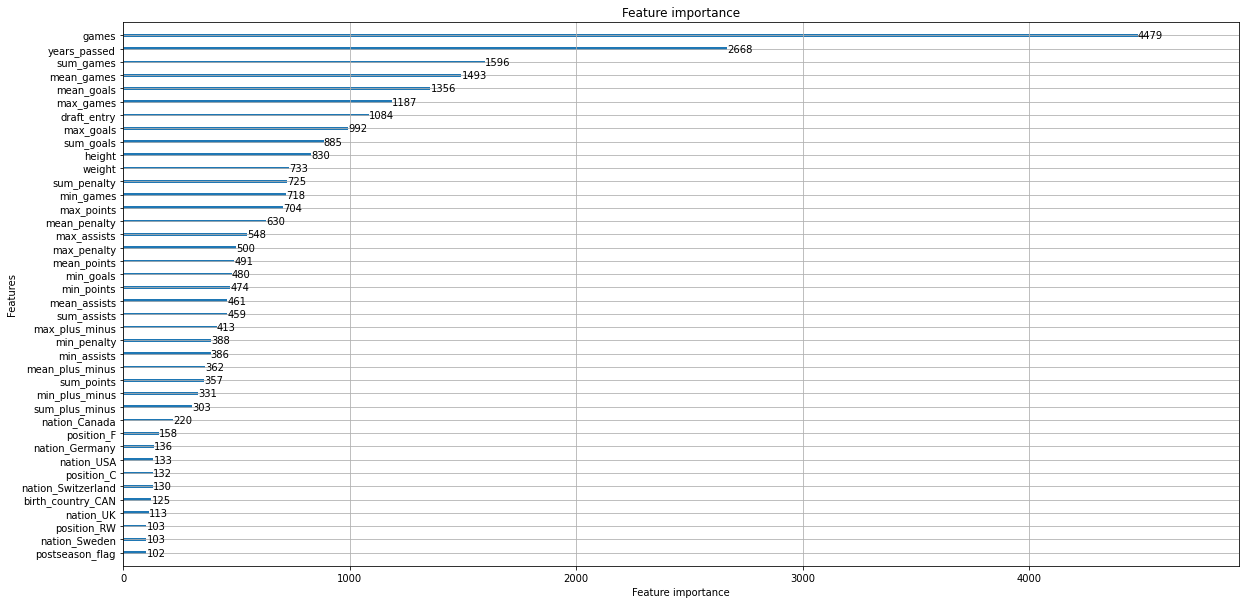

In [40]:
plot_importance(model, max_num_features=40, figsize=(20, 10))